Finetuning Llama3 8B on Aptos smart contract vulnerability analysis

Credits to the Github
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
</div>


Installing Dependencies

In [1]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

Using Unsloth/FastLanguageModel to to effeciently load the model

In [2]:
# Importing the necessary dependencies

from unsloth import FastLanguageModel
from transformers import TextStreamer
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [3]:
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True  # loading weights/biases in 4 bits


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models
)

# The model is loaded

==((====))==  Unsloth: Fast Llama patching release 2024.8
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

_________

<h1>Inference  without finetuning</h1>

<h3>Data Prep</h3>
We are going to use this synthetically created Alpaca dataset    
<a href="https://huggingface.co/datasets/ArmurAI/Aptos_vulnerability_audit_dataset">Aptos SC<a>


In [4]:
# @title Aptos Smart Contract
ExampleCode ='''
module QuantumFinance::advanced_defi_platform {
    use std::signer;
    use aptos_framework::coin;
    use aptos_framework::timestamp;
    use aptos_framework::account;
    use aptos_std::table::{Self, Table};

    struct LiquidityPool<phantom CoinTypeA, phantom CoinTypeB> has key {
        reserve_a: coin::Coin<CoinTypeA>,
        reserve_b: coin::Coin<CoinTypeB>,
        lp_tokens: u64,
        fee_percentage: u64,
        last_k: u128,
    }

    struct UserInfo has key {
        lp_balances: Table<address, u64>,
        last_interaction: u64,
        cumulative_rewards: u64,
    }

    struct PoolInfo has key {
        total_volume: u128,
        treasury: coin::Coin<CoinTypeA>,
    }

    const MIN_LIQUIDITY: u64 = 1000;
    const BASIS_POINTS: u64 = 10000;
    const PRECISION_FACTOR: u128 = 1000000000000;

    public fun initialize_pool<CoinTypeA, CoinTypeB>(
        account: &signer,
        initial_a: coin::Coin<CoinTypeA>,
        initial_b: coin::Coin<CoinTypeB>,
        fee_percentage: u64,
    ) {
        let sender = signer::address_of(account);
        assert!(!exists<LiquidityPool<CoinTypeA, CoinTypeB>>(sender), 1);
        assert!(fee_percentage <= 500, 2);

        let reserve_a_value = coin::value(&initial_a);
        let reserve_b_value = coin::value(&initial_b);
        assert!(reserve_a_value >= MIN_LIQUIDITY && reserve_b_value >= MIN_LIQUIDITY, 3);

        let initial_lp = (reserve_a_value as u128) * (reserve_b_value as u128);
        let initial_k = initial_lp / PRECISION_FACTOR;

        let pool = LiquidityPool {
            reserve_a: initial_a,
            reserve_b: initial_b,
            lp_tokens: (initial_lp as u64),
            fee_percentage,
            last_k: initial_k,
        };

        move_to(account, pool);
        move_to(account, PoolInfo { total_volume: 0, treasury: coin::zero<CoinTypeA>() });
    }

    public fun add_liquidity<CoinTypeA, CoinTypeB>(
        account: &signer,
        coin_a: coin::Coin<CoinTypeA>,
        coin_b: coin::Coin<CoinTypeB>,
    ) acquires LiquidityPool, UserInfo {
        let sender = signer::address_of(account);
        let pool = borrow_global_mut<LiquidityPool<CoinTypeA, CoinTypeB>>(@QuantumFinance);

        let deposit_a = coin::value(&coin_a);
        let deposit_b = coin::value(&coin_b);

        let reserve_a = coin::value(&pool.reserve_a);
        let reserve_b = coin::value(&pool.reserve_b);

        let coin_a_amount = deposit_a;
        let coin_b_amount = (deposit_a as u128) * (reserve_b as u128) / (reserve_a as u128);

        if ((coin_b_amount as u64) > deposit_b) {
            coin_b_amount = (deposit_b as u128);
            coin_a_amount = coin_b_amount * (reserve_a as u128) / (reserve_b as u128);
        };

        let lp_tokens_to_mint = (coin_a_amount as u64) * pool.lp_tokens / reserve_a;

        coin::merge(&mut pool.reserve_a, coin::extract(&mut coin_a, (coin_a_amount as u64)));
        coin::merge(&mut pool.reserve_b, coin::extract(&mut coin_b, (coin_b_amount as u64)));

        if (coin::value(&coin_a) > 0) {
            coin::deposit(sender, coin_a);
        };
        if (coin::value(&coin_b) > 0) {
            coin::deposit(sender, coin_b);
        };

        pool.lp_tokens = pool.lp_tokens + lp_tokens_to_mint;
        update_user_balance(sender, lp_tokens_to_mint);
    }

    public fun swap<CoinTypeIn, CoinTypeOut>(
        account: &signer,
        coin_in: coin::Coin<CoinTypeIn>,
        min_amount_out: u64,
    ): coin::Coin<CoinTypeOut> acquires LiquidityPool, PoolInfo {
        let sender = signer::address_of(account);
        let pool = borrow_global_mut<LiquidityPool<CoinTypeIn, CoinTypeOut>>(@QuantumFinance);

        let amount_in = coin::value(&coin_in);
        let reserve_in = coin::value(&pool.reserve_a);
        let reserve_out = coin::value(&pool.reserve_b);

        let amount_out = calculate_output(amount_in, reserve_in, reserve_out, pool.fee_percentage);
        assert!(amount_out >= min_amount_out, 4);

        coin::merge(&mut pool.reserve_a, coin_in);
        let coin_out = coin::extract(&mut pool.reserve_b, amount_out);

        let pool_info = borrow_global_mut<PoolInfo>(@QuantumFinance);
        pool_info.total_volume = pool_info.total_volume + (amount_in as u128);

        let k = (coin::value(&pool.reserve_a) as u128) * (coin::value(&pool.reserve_b) as u128);
        if (k < pool.last_k) {
            let diff = (((pool.last_k - k) / PRECISION_FACTOR) as u64);
            let fee = coin::extract(&mut pool.reserve_a, diff);
            coin::merge(&mut pool_info.treasury, fee);
        };
        pool.last_k = k / PRECISION_FACTOR;

        coin_out
    }

    fun calculate_output(amount_in: u64, reserve_in: u64, reserve_out: u64, fee_percentage: u64): u64 {
        let amount_in_with_fee = (amount_in as u128) * (BASIS_POINTS - fee_percentage);
        let numerator = amount_in_with_fee * (reserve_out as u128);
        let denominator = ((reserve_in as u128) * BASIS_POINTS) + amount_in_with_fee;
        ((numerator / denominator) as u64)
    }

    fun update_user_balance(user: address, amount: u64) acquires UserInfo {
        if (!exists<UserInfo>(user)) {
            move_to(&account::create_signer_with_capability(&account::create_test_signer_cap(user)), UserInfo {
                lp_balances: table::new(),
                last_interaction: timestamp::now_microseconds(),
                cumulative_rewards: 0,
            });
        };

        let user_info = borrow_global_mut<UserInfo>(user);
        let current_balance = table::borrow_mut_with_default(&mut user_info.lp_balances, @QuantumFinance, 0);
        *current_balance = *current_balance + amount;
        user_info.last_interaction = timestamp::now_microseconds();
    }

    public fun claim_rewards(account: &signer) acquires UserInfo, PoolInfo {
        let sender = signer::address_of(account);
        let user_info = borrow_global_mut<UserInfo>(sender);
        let pool_info = borrow_global_mut<PoolInfo>(@QuantumFinance);

        let time_elapsed = timestamp::now_microseconds() - user_info.last_interaction;
        let user_lp_balance = *table::borrow(&user_info.lp_balances, @QuantumFinance);

        let reward = (user_lp_balance as u128) * time_elapsed * (pool_info.total_volume as u128) / PRECISION_FACTOR;
        user_info.cumulative_rewards = user_info.cumulative_rewards + (reward as u64);

        let reward_coin = coin::extract(&mut pool_info.treasury, (reward as u64));
        coin::deposit(sender, reward_coin);

        user_info.last_interaction = timestamp::now_microseconds();
    }
}
'''

In [5]:
alpaca_prompt = """You are an expert in Aptos smart contract development and security auditing. Your task is to analyze the provided Aptos smart contract and provide a comprehensive security analysis. Check for common vulnerabilities specific to aptos contracts
please provide a detailed explanation for each vulnerability
### Smart Contract:
{}

### Vulnerabilities:
{}"""

FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        ExampleCode,
        ""
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128)
predictions = tokenizer.batch_decode(outputs, skip_special_tokens = True)
gen_out = predictions[0]
gen_res = gen_out[gen_out.index("### Vulnerabilities:")+len("### Vulnerabilities:")+1:]
print(gen_res)


1. In the `initialize_pool` function, the `reserve_a_value` and `reserve_b_value` variables are calculated using the `coin::value` function, which can be exploited by an attacker to execute a reentrancy attack. The `reserve_a_value` and `reserve_b_value` variables should be calculated using the `coin::amount` function instead, which is a more secure way of calculating the amount of a coin.

2. In the `add_liquidity` function, the `coin_b_amount` variable is calculated using the `deposit_b` variable, which can be exploited by an attacker to execute a


As you can see the output is very vague.
We are going to fix that using **Finetuning**

---------

<h1>Finetuning

In [6]:
#Generating Peft version of the model to

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<h2>Mapping the dataset</h2>

In [7]:
alpaca_prompt = """You are an expert in Aptos smart contract development and security auditing. Your task is to analyze the provided Aptos smart contract and provide a comprehensive security analysis. Check for common vulnerabilities specific to Aptos contracts

### Smart Contract:
{}

### Vulnerabilities:
{}"""

data_link = "ArmurAI/Aptos_vulnerability_audit_dataset"

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    scs       = examples["code"]
    vul     =  examples["vulnerabilities"]
    texts = []
    for s,v in zip(scs,vul):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!

        output_desired = '''The vulnerabilities found in the following code are : \n'''
        for i in range(len(v)):
            output_desired+= (str(i+1)+ ") " + str(v[i]) +"\n")
        v1 = output_desired
        text = alpaca_prompt.format(s,v1) + EOS_TOKEN
        texts.append(text)

    return { "text" : texts, }
pass

## Loading the dataset

# hugging face datase
dataset = load_dataset(data_link, split = "train")

# local file as a dataset (Please upload it in the folder)
#dataset = load_dataset("json", data_files="data.json", split = "train")

dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split:   0%|          | 0/449 [00:00<?, ? examples/s]

Map:   0%|          | 0/449 [00:00<?, ? examples/s]

<a name="Train"></a>
<h3>Train the model</h3>
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [8]:
# Defining SFTTrainer

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,  # Depends on the model
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/449 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


----------

<h2> Training</h2>

In [9]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 449 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.362300
2,1.527900
3,1.381200
4,1.322000
5,1.039900
6,1.144900
7,0.922800
8,0.791900
9,0.663600
10,0.642300


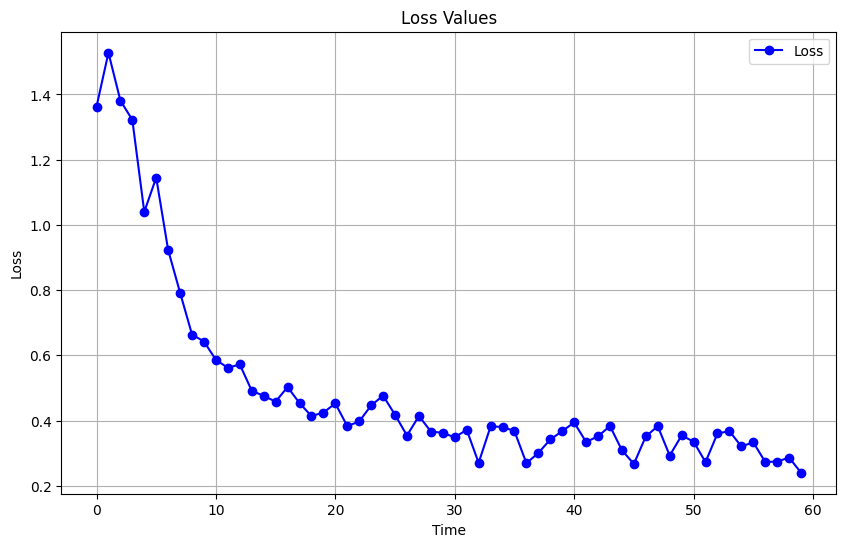

In [10]:
loss = []
data_loss = trainer.state.log_history
for i in range(len(data_loss)-1):
    loss.append(data_loss[i]["loss"])

indices = list(range(len(loss)))

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(indices, loss, 'b-', marker='o', label='Loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Loss Values')
plt.legend()
plt.grid(True)
plt.show()

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [11]:
# alpaca_prompt = Copied from above
alpaca_prompt = """You are an expert in Aptos smart contract development and security auditing. Your task is to analyze the provided Aptos smart contract and provide a comprehensive security analysis. Check for all common vulnerabilities specific to Aptos contracts

### Smart Contract:
{}

### Vulnerabilities:
{}"""



FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        ExampleCode,
        ""
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128)
predictions = tokenizer.batch_decode(outputs, skip_special_tokens = True)
gen_out = predictions[0]
gen_res = gen_out[gen_out.index("### Vulnerabilities:")+len("### Vulnerabilities:")+1:]
print(gen_res)

The vulnerabilities found in the following code are : 
1) No slippage protection
2) Lack of access control for pool creation
3) Missing events for liquidity and reward distribution
4) No mechanism to burn LP tokens
5) Potential for front-running on swaps
6) No checks for zero reserve amounts
7) Missing fee distribution for treasury
8) Potential for reentrancy attacks
9) Lack of access control for claiming rewards
10) No mechanism to update pool fee percentage



This output is way better and precise, after checking the code manually these are the exact vulnerabilities found in the smart contract

In [ ]:
model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

Save your model to huggingface

<h1>And we are done ..🥳</h1>